In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Layer, Input, Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout, Conv2DTranspose
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model, Sequential
from keras.layers import Concatenate, UpSampling2D
from tensorflow.keras.layers import Add, Activation, Multiply
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


dataset = "/content/drive/MyDrive/GAN/Semantic segmentation dataset"
if not os.path.exists(dataset):
    raise FileNotFoundError(f"Dataset path not found: {dataset}")

# Collect directories, skipping "classes.json"
listDir = [dir for dir in sorted(os.listdir(dataset)) if dir != "classes.json"]


Mounted at /content/drive


In [3]:
def loadImg(dataset, dirTile):
    input_img, mask_img = [], []
    dir_path = os.path.join(dataset, dirTile)

    # Ensure directory has exactly two subdirectories
    subdirs = sorted(os.listdir(dir_path))
    if len(subdirs) != 2:
        raise ValueError(f"Expected 2 subdirectories in {dir_path}, found {len(subdirs)}")

    inpDir, maskDir = subdirs

    imgDirs = sorted(os.listdir(os.path.join(dir_path, inpDir)))
    mask_imgDirs = sorted(os.listdir(os.path.join(dir_path, maskDir)))

    for imgDir in imgDirs:
        img_path = os.path.join(dir_path, inpDir, imgDir)
        img = load_img(img_path, target_size=(224, 224))
        img = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0
        input_img.append(img)

    for mask_imgDir in mask_imgDirs:
        mask_path = os.path.join(dir_path, maskDir, mask_imgDir)
        mask = load_img(mask_path, target_size=(224, 224))
        mask = tf.convert_to_tensor(mask, dtype=tf.float32) / 255.0
        mask_img.append(mask)

    return input_img, mask_img

In [4]:
def loadData(dataset=dataset, listDir=listDir):
    imgs_data, masks_data = [], []
    for dirTile in listDir:
        input_imgs, mask_imgs = loadImg(dataset, dirTile)
        imgs_data.extend(input_imgs)
        masks_data.extend(mask_imgs)
    return imgs_data, masks_data


In [5]:
input_imgs, mask_imgs = loadData()

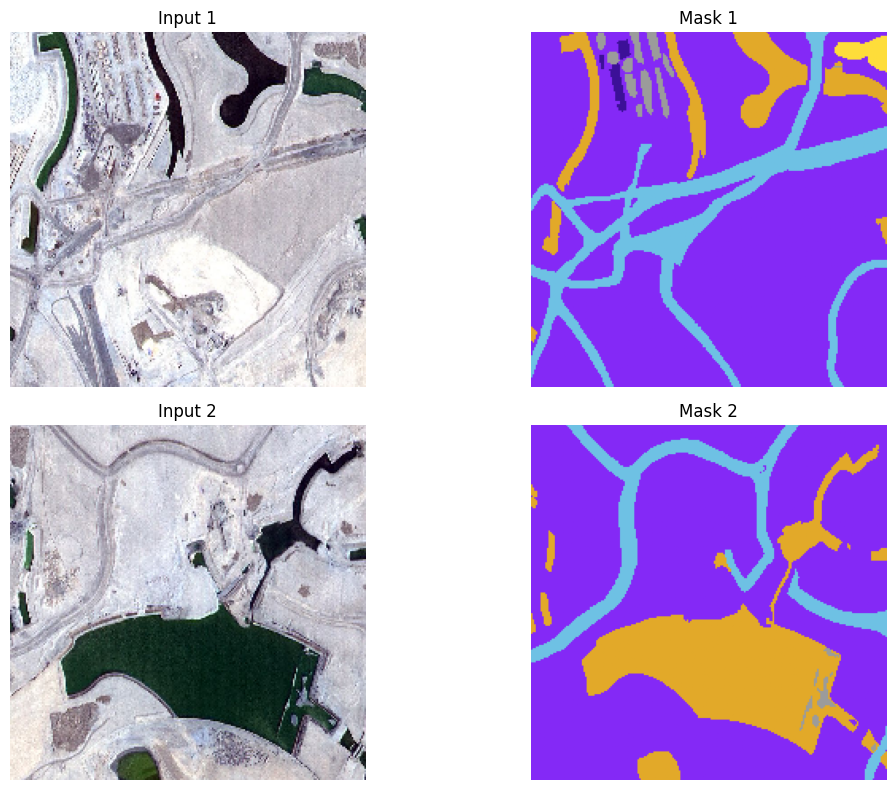

In [6]:
plt.figure(figsize=(12, 8))

# Displaying the first input image and its mask
plt.subplot(2, 2, 1)
plt.title("Input 1")
plt.imshow(input_imgs[0])
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Mask 1")
plt.imshow(mask_imgs[0])
plt.axis("off")

# Displaying the second input image and its mask
plt.subplot(2, 2, 3)
plt.title("Input 2")
plt.imshow(input_imgs[1])
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Mask 2")
plt.imshow(mask_imgs[1])
plt.axis("off")

plt.tight_layout()
plt.show()


In [10]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    input_imgs, mask_imgs, test_size=0.2, shuffle=True, random_state=42
)

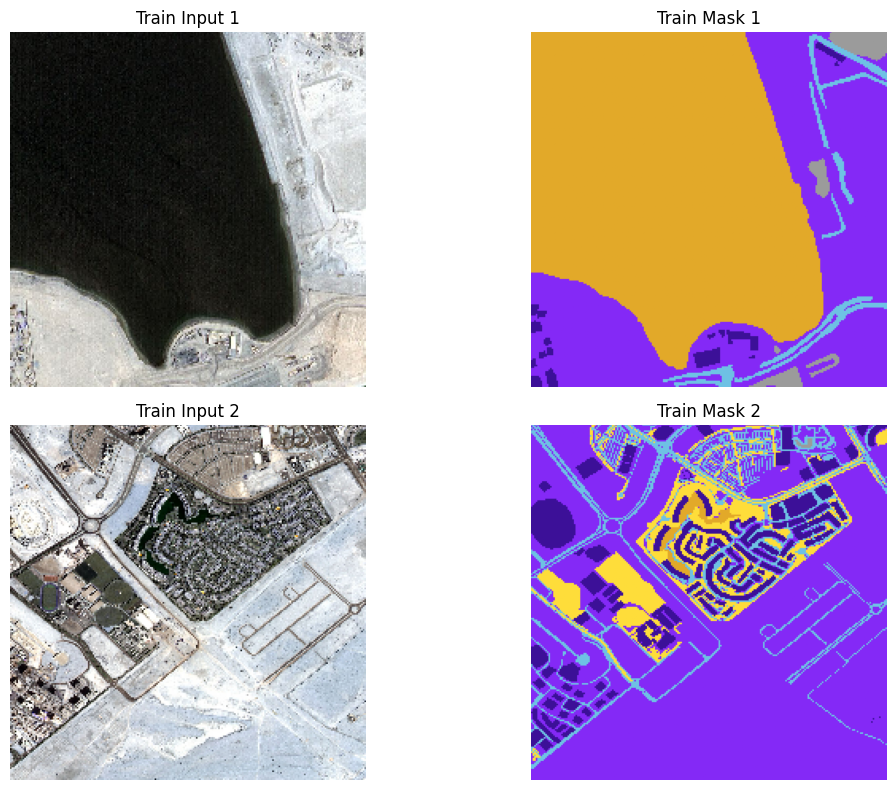

In [13]:
plt.figure(figsize=(12, 8))

# Displaying the first input image and its mask
plt.subplot(2, 2, 1)
plt.imshow(train_imgs[0])
plt.title("Train Input 1")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(train_masks[0])
plt.title("Train Mask 1")
plt.axis("off")

# Displaying the second input image and its mask
plt.subplot(2, 2, 3)
plt.imshow(train_imgs[1])
plt.title("Train Input 2")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(train_masks[1])
plt.title("Train Mask 2")
plt.axis("off")

plt.tight_layout()
plt.show()


In [14]:
def attention_gate(x, g, filters):
    theta_x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(filters, kernel_size=1, strides=1, padding='same')(g)
    add = Add()([theta_x, phi_g])
    act = Activation('relu')(add)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(act)
    sigmoid = Activation('sigmoid')(psi)
    attention = Multiply()([x, sigmoid])
    return attention

In [15]:
def Conv(x, dropout, filters):
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(dropout)(x)
    pool = MaxPooling2D(pool_size=(2, 2))(x)
    return x, pool

# Define UpSample block with attention
def UpSample(x, skip_connect, dropout, filters):
    x = UpSampling2D(size=(2, 2))(x)
    attention = attention_gate(skip_connect, x, filters)
    x = Concatenate(axis=-1)([attention, x])
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=3, padding='same', activation='relu')(x)
    return x

In [16]:
def UNet(x, dropout, conv=[32, 64, 128, 256, 512]):
    conv1, pool1 = Conv(x, dropout, conv[0])
    conv2, pool2 = Conv(pool1, dropout, conv[1])
    conv3, pool3 = Conv(pool2, dropout, conv[2])
    conv4, pool4 = Conv(pool3, dropout, conv[3])

    conv5 = Conv2D(filters=conv[4], kernel_size=3, padding='same', activation='relu')(pool4)
    conv5 = Dropout(dropout)(conv5)
    conv5 = BatchNormalization()(conv5)

    conv6 = UpSample(conv5, conv4, dropout, conv[4])
    conv7 = UpSample(conv6, conv3, dropout, conv[3])
    conv8 = UpSample(conv7, conv2, dropout, conv[2])
    conv9 = UpSample(conv8, conv1, dropout, conv[1])

    result = Conv2D(filters=3, kernel_size=1, padding='same', activation='sigmoid')(conv9)
    return result

In [17]:
input_layer = Input(shape=(224, 224, 3))
output_layer = UNet(input_layer, dropout=0.1)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 224, 224, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 112, 112, 64)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 56, 56, 128)    │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 128)    │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 11,581,223 (44.18 MB)

 Trainable params: 11,577,319 (44.16 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [18]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [26]:
# Convert lists to numpy arrays
train_imgs_np = np.array(train_imgs, dtype=np.float32)
train_masks_np = np.array(train_masks, dtype=np.float32)
test_imgs_np = np.array(test_imgs, dtype=np.float32)
test_masks_np = np.array(test_masks, dtype=np.float32)

history = model.fit(
    train_imgs_np, train_masks_np,
    batch_size=32,
    epochs=10,
    validation_data=(test_imgs_np, test_masks_np)
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 211s 100s/step - accuracy: 0.9142 - loss: 0.5364 - val_accuracy: 0.7086 - val_loss: 0.6545
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8885 - loss: 0.5456 - val_accuracy: 0.7089 - val_loss: 0.6644
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8854 - loss: 0.5400 - val_accuracy: 0.7130 - val_loss: 0.6640
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8932 - loss: 0.5373 - val_accuracy: 0.7133 - val_loss: 0.6622
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8973 - loss: 0.5379 - val_accuracy: 0.7101 - val_loss: 0.6615
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9047 - loss: 0.5376 - val_accuracy: 0.7089 - val_loss: 0.6603
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9052 - loss: 0.5378 - val_accuracy: 0.7086 - val_loss: 0.6585
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9156 - loss: 0.5309 - val_accuracy: 0.7086 - val_loss: 0.6545
Epoch 9/10


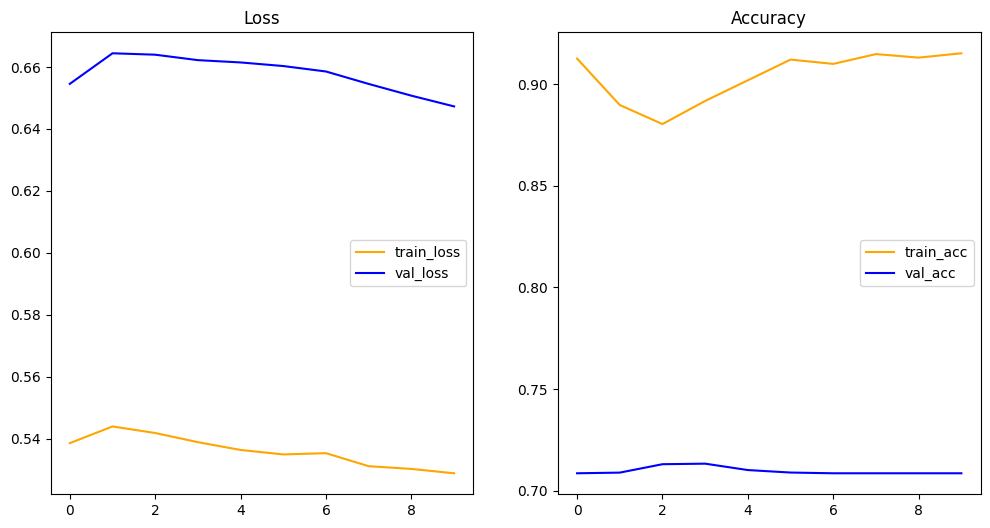

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], c='orange', label='train_loss')
plt.plot(history.history['val_loss'], c='blue', label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], c='orange', label='train_acc')
plt.plot(history.history['val_accuracy'], c='blue', label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


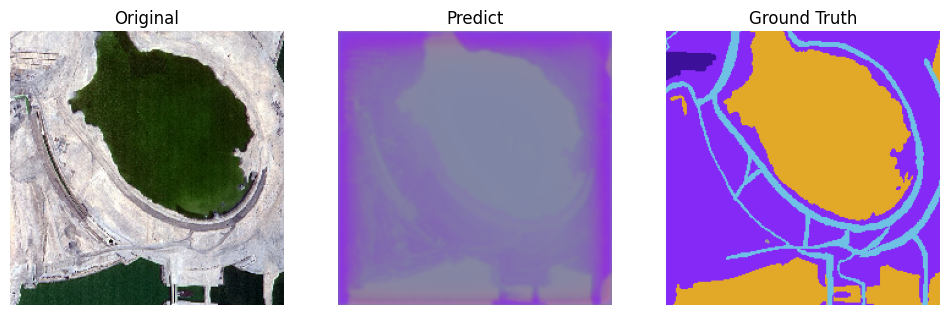

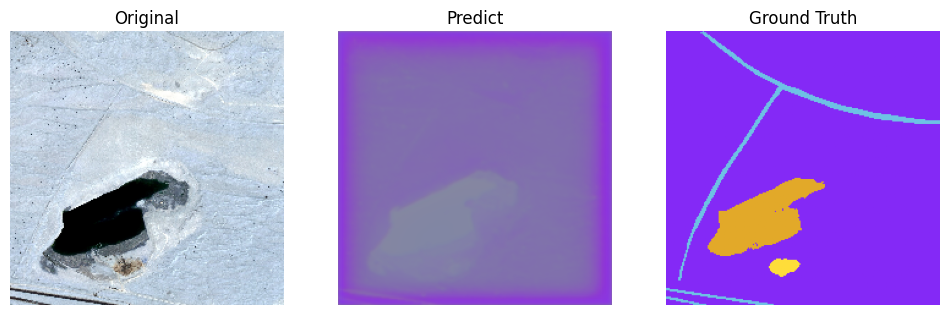

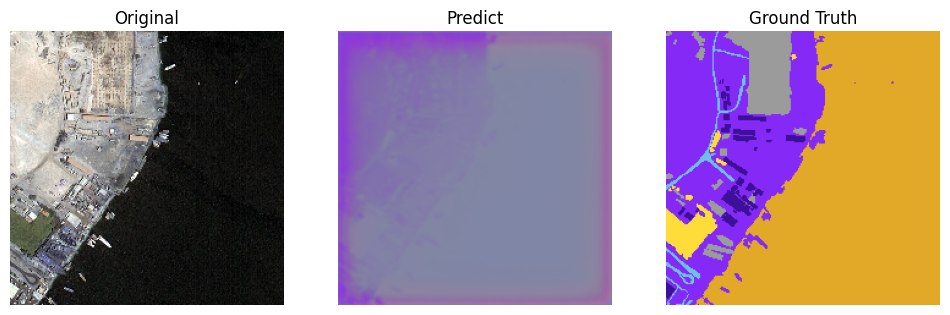

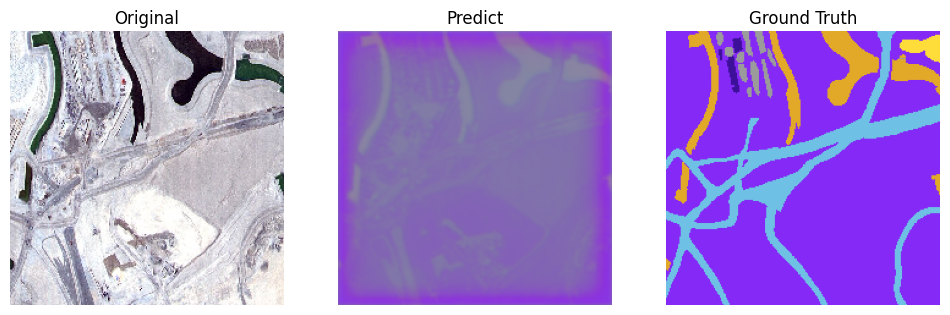

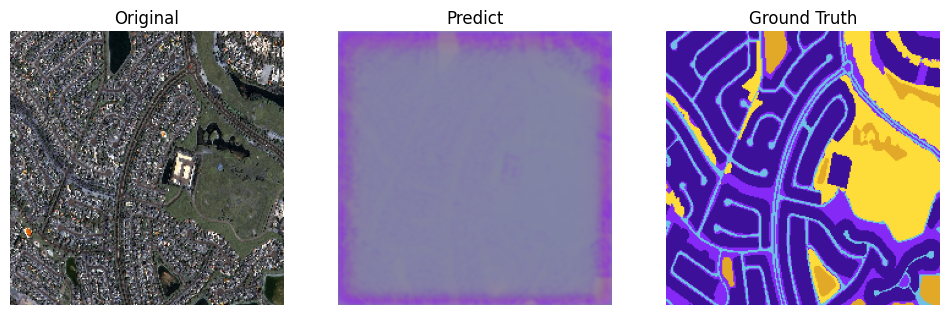

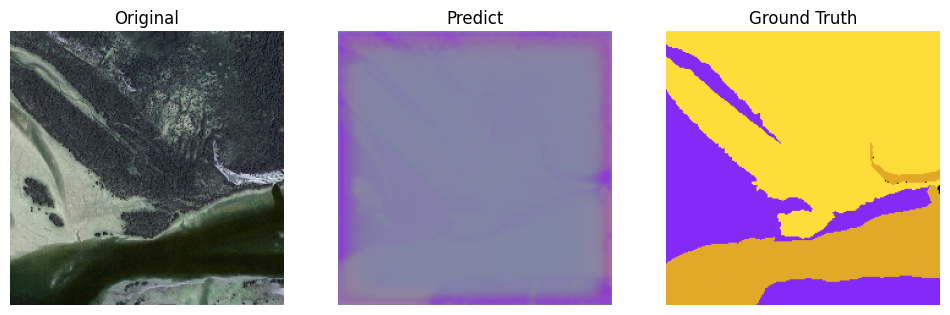

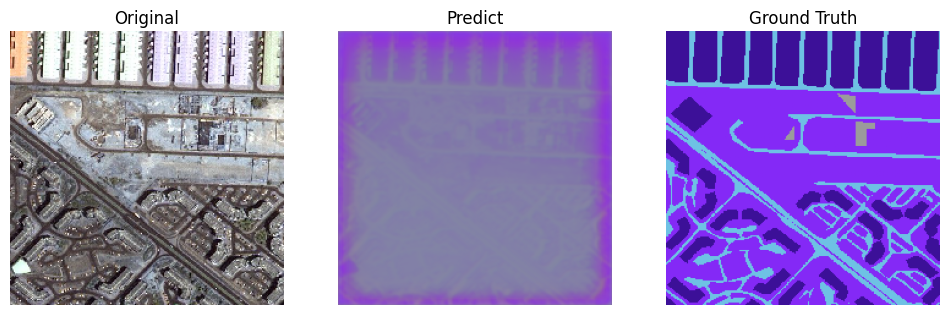

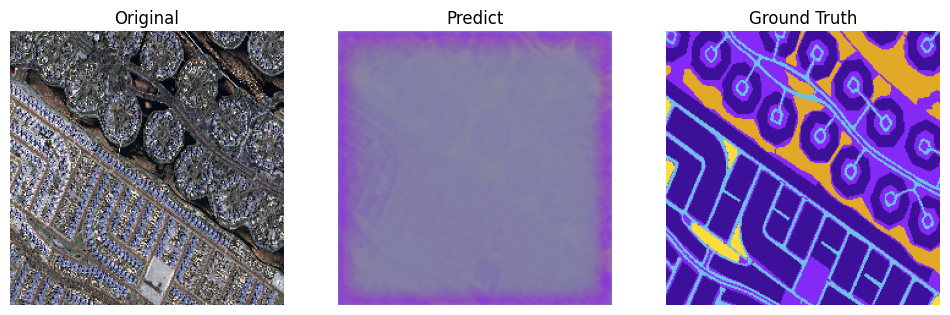

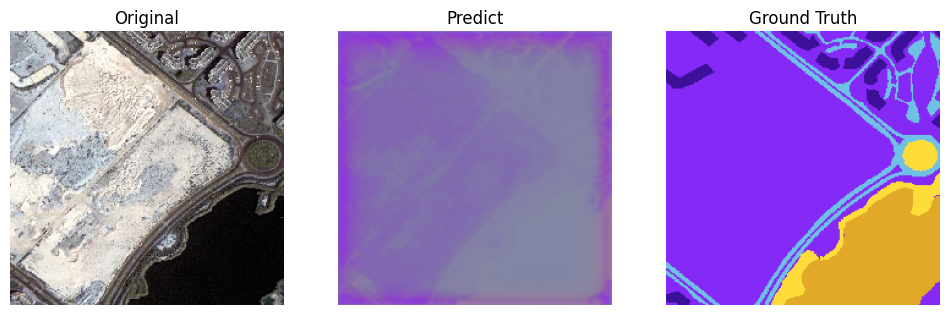

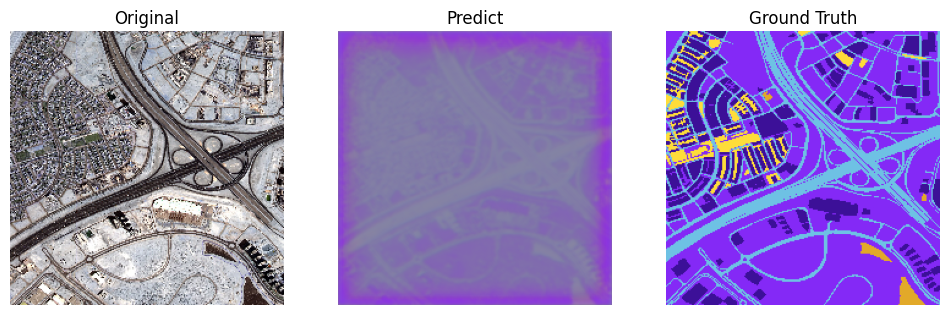

In [29]:
images_predict = model.predict(np.array(test_imgs))

def show_result(id):
    fig, ax = plt.subplots(1, 3, figsize=(12, 7))
    ax[0].set_title('Original')
    ax[0].imshow(test_imgs[id])
    ax[0].axis("off")

    ax[1].set_title('Predict')
    ax[1].imshow(images_predict[id])
    ax[1].axis("off")

    ax[2].set_title('Ground Truth')
    ax[2].imshow(test_masks[id])
    ax[2].axis("off")

for id in range(10):
    show_result(id)